# Planaria single-cell

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import pyemb as eb

## Load data

This section uses [data](https://shiny.mdc-berlin.de/psca/) from the paper ['Cell Type Atlas and Lineage Tree of a Whole Complex Animal by Single-Cell Transcriptomics'](https://www.science.org/doi/abs/10.1126/science.aaq1723). It contains expression levels of $p= 5821$ genes measured across $n=5000$ individual cells from adult planarians, a type of flatworm. Such data offer the possibility of discovering the cell lineage tree of an entire animal: the
aim is to find out if the data reflect the tree-structured process by which stem cells differentiate into a variety of distinct cell types. These data were prepared using the Python package [Scanpy](https://scanpy.readthedocs.io/en/stable/index.html), where the script on how to do this can be found [here](https://nbviewer.org/github/rajewsky-lab/planarian_lineages/blob/master/paga/preprocessing.ipynb).

In [3]:
Y = np.array(pd.read_csv('data/planaria_sample_data.csv', index_col=0))
(n,p) = Y.shape
print('Data matrix is', n, 'samples by', p, 'features')

labels = np.genfromtxt('data/sample_annotation_5000.txt', delimiter=',', dtype=str) 
ordered_cats = np.genfromtxt('data/planaria_ordered_cats.csv', delimiter=',', dtype=str)

colors = pd.read_csv('data/colors_dataset.txt', header=None, sep='\t')
colors = {k: c for k, c in colors.values}

Data matrix is 5000 samples by 5821 features


## Dimension selection and visualisation

Perform dimension selection using Wasserstein distances, as explained in ['Statistical exploration of the Manifold Hypothesis'](https://arxiv.org/pdf/2208.11665).

In [4]:
# ws, dim = eb.wasserstein_dimension_select(Y, range(20), split=0.5)
# print("Selected dimension: {}".format(dim))
dim = 14


Now, perform PCA with the embedding function and visualise. 

In [5]:
zeta = p**-.5 * eb.embed(Y, d=dim, version='full')

In [7]:
## TSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity = 30).fit_transform(zeta)

In [71]:
import matplotlib.pyplot as plt
def snapshot_plot(
    embedding,
    n = None,
    node_labels = None,
    c = None,
    points_of_interest = None,
    point_labels=[],
    max_cols=4,
    add_legend=False,
    bbox_to_anchor=(1,.5),
    legend_side = 'right',
    max_legend_cols=5,
    title = None,
    sharex=False,
    sharey=False,
    figsize_scale = 5,
    **kwargs,
):
    
    if n is None:   
        n = embedding.shape[0]
    if node_labels is None:
        node_labels = np.zeros(n)
        
    if isinstance(embedding, list):
        embedding = np.stack(embedding, axis=0)
        
    if points_of_interest is None:  
        points_of_interest = list(range(embedding.shape[0]))

    # Subplot for each time point
    num_cols = min(len(points_of_interest), max_cols)
    num_rows = (len(points_of_interest) + num_cols - 1) // num_cols
    fig, axs = plt.subplots(
        figsize=(figsize_scale * num_cols, figsize_scale * num_rows),
        sharex=sharex,
        sharey=sharey,
        ncols=num_cols,
        nrows=num_rows,
    )

    if len(embedding.shape) == 2:
        T = embedding.shape[0] // n
        embedding = embedding.reshape(T, n, embedding.shape[1])

    if isinstance(c, str) or isinstance(c, np.ndarray) or isinstance(c, list):   
        plot_colours = c
    if isinstance(c, dict):
        plot_colours = [c[l] for l in node_labels]
    if c is None:
        plot_colours = pd.factorize(np.array(node_labels))[0]
        

    for t_idx, t in enumerate(points_of_interest):
        if num_rows == 1:
            if num_cols == 1:
                subplot = axs
            else:
                subplot = axs[t_idx]
        else:
            t_row = t_idx // num_cols
            t_col = t_idx % num_cols
            subplot = axs[t_row, t_col]

        scatter = subplot.scatter(
            embedding[t, :, 0],
            embedding[t, :, 1],
            c=plot_colours,
            label=node_labels,
            **kwargs,
        )

        if title is not None: 
            if not isinstance(title,list):
                title = [title]
            if len(title) == point_labels:
                subplot.set_title(title[t_idx])
            else:
                subplot.set_title(title[0])
        else:
            if len(point_labels) > 0:
                subplot.set_title(point_labels[t_idx])
            else:
                subplot.set_title(f"Time {t}")

        subplot.grid(alpha=0.2)
        subplot.set_xticklabels([])
        subplot.set_yticklabels([])

    # Hide any unused subplots
    if len(points_of_interest) < num_rows * num_cols:
        for idx in range(len(points_of_interest), num_rows * num_cols):
            fig.delaxes(axs.flatten()[idx])
    
    if add_legend:
        legend_labels = sorted(list(set(node_labels)))
        colour_dict = {node_labels[i]: c for i, c in enumerate(plot_colours)}
        # Add legend
        legend_handles = []
        if c is None: 
            # Extract and print colormap
            colormap = scatter.get_cmap()
            norm = scatter.norm
            num_to_colours = {label: colormap(norm(label)) for label in np.unique(plot_colours)}
            num_to_label = {value: key for key, value in colour_dict.items()}
            colour_dict = {num_to_label[label] :num_to_colours[label] for label in np.unique(plot_colours)}
            print(colour_dict)


        for label in legend_labels:
            legend_handles.append(
            plt.Line2D(
                    [0], [0], marker="o", color=colour_dict[label], linestyle="None", label=label
            )
            )
        
        if legend_side == 'right':
            attach_to = num_cols-1
        if legend_side == 'left':
            attach_to = 0
        print(attach_to)
        if num_rows == 1:
            if num_cols == 1:
                axs.legend(handles=legend_handles,ncols = min(len(legend_labels), max_legend_cols), loc='center left', bbox_to_anchor=bbox_to_anchor)
            else:
                axs[attach_to].legend(handles=legend_handles,ncols = min(len(legend_labels), max_legend_cols), loc='center left', bbox_to_anchor=bbox_to_anchor)
        else:
            axs[num_rows-1,attach_to].legend(handles=legend_handles,ncols=min(len(legend_labels), max_legend_cols), loc='center left', bbox_to_anchor=bbox_to_anchor)
            
    return fig, axs

1


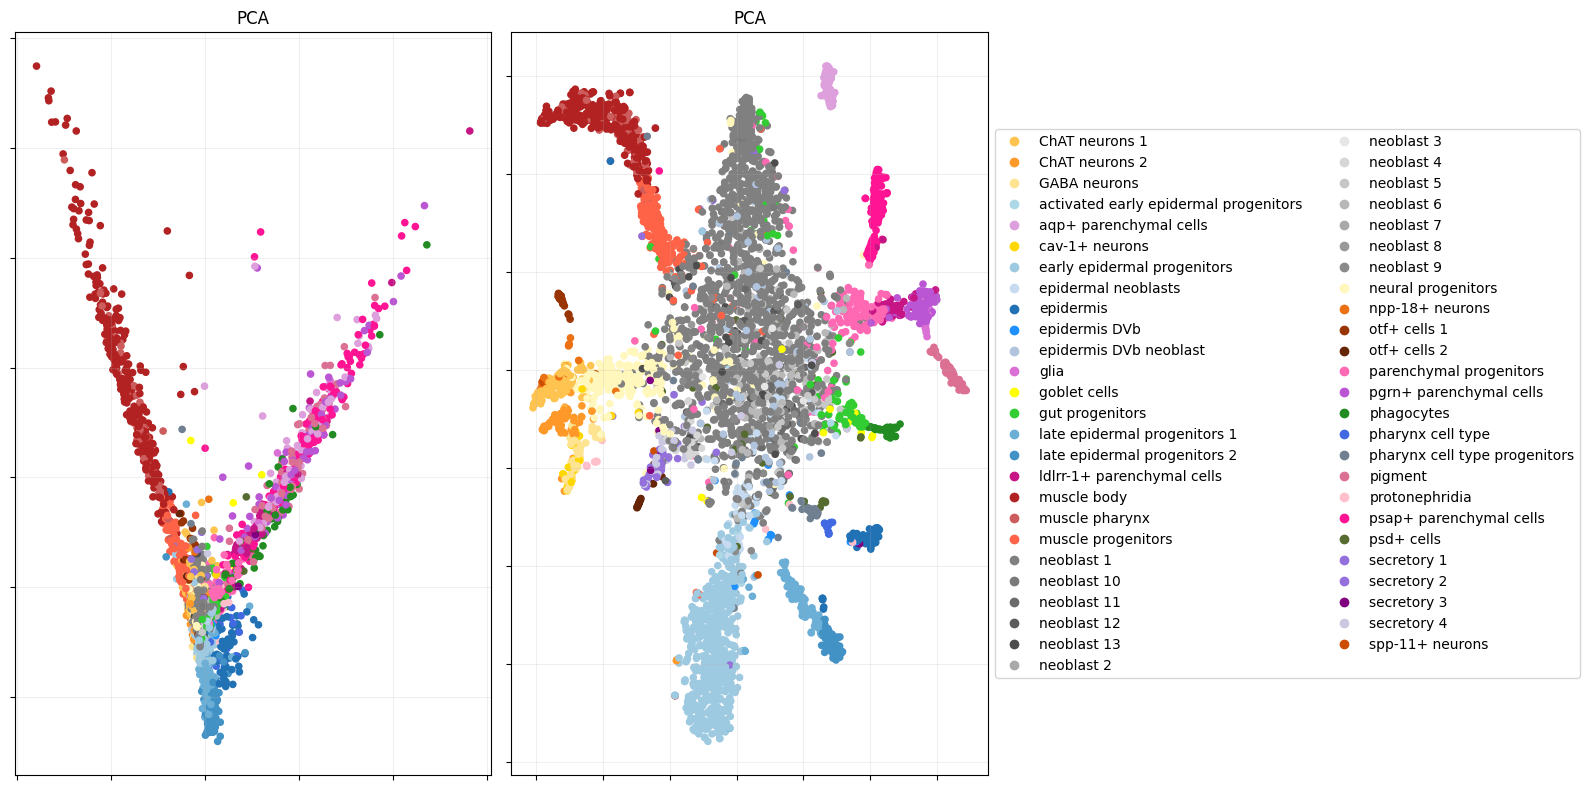

In [72]:
pca_fig, axs = snapshot_plot(
    embedding = [zeta[:,:2],tsne], 
    n = n, 
    node_labels = labels.tolist(), 
    c = colors,
    add_legend=True, 
    title = ['PCA','tSNE'],
    max_legend_cols = 2,
    figsize_scale = 8,
    # Apply other matplotlib settings
    s=20,
)
plt.tight_layout()

In [62]:
axs.get_cmap()

AttributeError: 'Axes' object has no attribute 'get_cmap'

In [52]:
node_labels = labels.tolist()
c = colors
plot_colours = [c[l] for l in node_labels]

In [55]:
pca_fig, axs = snapshot_plot(
    embedding = zeta, 
    n = n, 
    node_labels = labels.tolist(), 
    c = colors,
    add_legend=True, 
    legend_adjust=-0.1,
    
    # Apply other matplotlib settings
    s=70,
)
plt.tight_layout()

/tmp/ipykernel_5745/2876843855.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


ValueError: Image size of 657439x432 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 500x500 with 1 Axes>

In [9]:
axs.get_legend_handles_labels()

([<matplotlib.collections.PathCollection at 0x798f61d53910>],
 ["['pharynx cell type progenitors', 'neoblast 1', 'GABA neurons', 'phagocytes', 'neoblast 1', 'neoblast 1', 'neoblast 1', 'neoblast 1', 'neoblast 1', 'ChAT neurons 1', 'muscle pharynx', 'neoblast 1', 'neoblast 1', 'neoblast 1', 'parenchymal progenitors', 'neoblast 1', 'neoblast 6', 'gut progenitors', 'neoblast 6', 'early epidermal progenitors', 'early epidermal progenitors', 'neoblast 10', 'neoblast 1', 'muscle body', 'early epidermal progenitors', 'neoblast 1', 'psd+ cells', 'neoblast 11', 'neoblast 1', 'neoblast 1', 'ChAT neurons 1', 'pigment', 'neoblast 6', 'muscle body', 'neoblast 1', 'neoblast 1', 'neoblast 1', 'muscle body', 'neoblast 9', 'neoblast 1', 'neural progenitors', 'ChAT neurons 2', 'ChAT neurons 2', 'neoblast 13', 'neural progenitors', 'neoblast 10', 'secretory 4', 'early epidermal progenitors', 'early epidermal progenitors', 'neural progenitors', 'pharynx cell type progenitors', 'neural progenitors', 'neobl

In [9]:
stop

NameError: name 'stop' is not defined

In [4]:
tree = eb.ConstructTree(zeta, epsilon=0.25)
tree.fit()

Performing clustering...
Calculating branch lengths...
Constructing tree...


100%|██████████| 250/250 [00:02<00:00, 100.28it/s]


BarnesHut Approximation  took  1.34  seconds
Repulsion forces  took  0.95  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.09  seconds


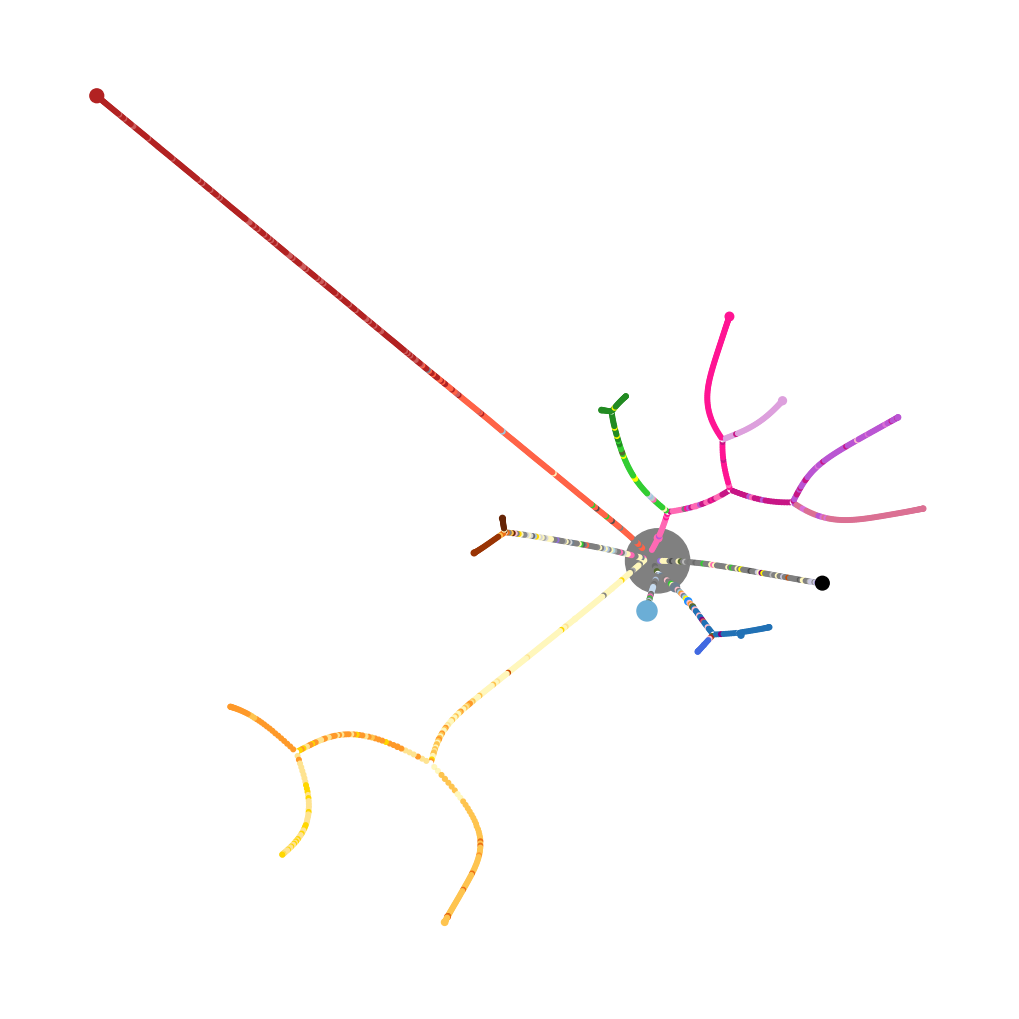

In [5]:
tree.plot(labels,colors, prog = 'twopi')